<a href="https://colab.research.google.com/github/Intina47/DEEP_LEARNING/blob/main/malaria/malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

DATA PREPARATION

In [5]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteNRA8YF/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for data in dataset[0].take(1):
  print(data)

DATA CLASIFICATION -specify VALIDATION AND TESTING DATA

In [6]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  training_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO)) #take 60% of the whole dataset to be training data
  val_test_dataset = dataset.skip((int(DATASET_SIZE*TRAIN_RATIO)))#skip the first 60% of the dataset
  valiadation_dataset = val_test_dataset.take(int(DATASET_SIZE*VAL_RATIO)) #take 20% of val_test_dataset
  test_dataset = val_test_dataset.skip(int(DATASET_SIZE*VAL_RATIO)) #take 20% the remaining dataset

  return training_dataset,valiadation_dataset,test_dataset

In [7]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

training_dataset,valiadation_dataset,test_dataset = split(dataset[0],TRAIN_RATIO, VAL_RATIO,TEST_RATIO)
# print(list(training_dataset.take(1).as_numpy_iterator()))
# print(list(valiadation_dataset.take(1).as_numpy_iterator()))
# print(list(test_dataset.take(1).as_numpy_iterator()))

DATA VISUALIZATION


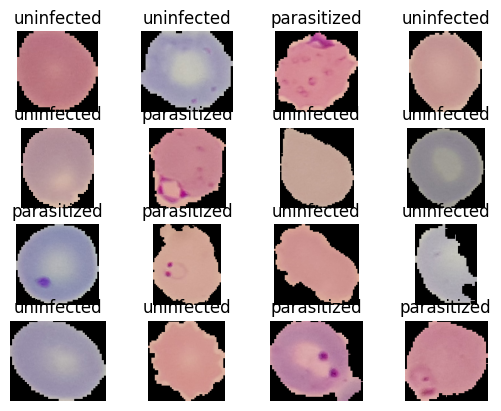

In [ ]:
for i ,(image, label) in enumerate(training_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(label)[1]

'a'

DATA PROCESSING

In [8]:
IMG_SIZE = 124
def img_resizing(image, label):
  return tf.image.resize(image, (IMG_SIZE,IMG_SIZE))/255.0,label

In [9]:
training_dataset = training_dataset.map(img_resizing) #speed processing
valiadation_dataset = valiadation_dataset.map(img_resizing)
test_dataset = test_dataset.map(img_resizing)

In [10]:
for image, label in valiadation_dataset.take(1):
  print('success fetching resized data!')

success fetching resized data!


In [11]:
training_dataset = training_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(20).prefetch(tf.data.AUTOTUNE)
valiadation_dataset = valiadation_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(20).prefetch(tf.data.AUTOTUNE)

MODEL

In [12]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1),
])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 16)       64        
 hNormalization)                                                 
                                                        

Compile model

In [13]:
lenet_model.compile(optimizer=Adam(learning_rate=1), loss=BinaryCrossentropy(), metrics='accuracy')

TRAINING MODEL

In [14]:
history = lenet_model.fit(training_dataset, validation_data=valiadation_dataset, epochs=20, verbose=1)

Epoch 1/20
827/827 [==============================] - 48s 41ms/step - loss: 7.6458 - accuracy: 0.4984 - val_loss: 7.5630 - val_accuracy: 0.5041
Epoch 2/20
827/827 [==============================] - 40s 49ms/step - loss: 7.6301 - accuracy: 0.4996 - val_loss: 7.5519 - val_accuracy: 0.5048
Epoch 3/20
827/827 [==============================] - 40s 49ms/step - loss: 7.6311 - accuracy: 0.4996 - val_loss: 7.5546 - val_accuracy: 0.5046
Epoch 4/20
827/827 [==============================] - 34s 41ms/step - loss: 7.6311 - accuracy: 0.4996 - val_loss: 7.5658 - val_accuracy: 0.5039
Epoch 5/20
827/827 [==============================] - 40s 49ms/step - loss: 7.6292 - accuracy: 0.4997 - val_loss: 7.5658 - val_accuracy: 0.5039
Epoch 6/20
827/827 [==============================] - 34s 40ms/step - loss: 7.6292 - accuracy: 0.4997 - val_loss: 7.5602 - val_accuracy: 0.5043
Epoch 7/20
827/827 [==============================] - 40s 49ms/step - loss: 7.6330 - accuracy: 0.4995 - val_loss: 7.5519 - val_accuracy:

Performance Measurement

In [1]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('model performace')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'])
plt.show()

NameError: ignored

TESTING

In [ ]:
test_dataset=test_dataset.batch(1)

In [ ]:
lenet_model.evaluate(test_dataset)

5513/5513 [==============================] - 31s 4ms/step - loss: 7.7085 - accuracy: 0.5003


[7.708514213562012, 0.5002720952033997]

In [1]:
def parasite_or_not(data_setlabel):
  if (data_setlabel < 0.5):
    return str('P')
  else:
    return str('U')


In [3]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

NameError: ignored

U
1/1 [==============================] - 0s 20ms/step
P
U
1/1 [==============================] - 0s 22ms/step
P
P
1/1 [==============================] - 0s 21ms/step
P
U
1/1 [==============================] - 0s 19ms/step
P
P
1/1 [==============================] - 0s 19ms/step
P
U
1/1 [==============================] - 0s 19ms/step
P
U
1/1 [==============================] - 0s 20ms/step
P
P
1/1 [==============================] - 0s 25ms/step
P
P
1/1 [==============================] - 0s 20ms/step
P


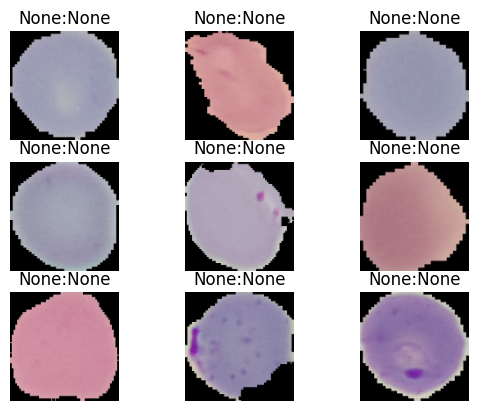

In [ ]:
#TODO: debug labels issue
for i, (image, label ) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')


test_data

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 124, 124, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>